v20_distilBERT_1の後継

ここでは９次元のセンサデータをなんとかdistilBERTで処理できるようにするノートブック  
distilBERTのワードエンベディングを全結合層にする。  
こうすることで一応は９次元センサデータを扱うことができると思う。  
ただそうするとセンサデータをトークン化する必要が必ずしもなくなってしまう。自然言語処理で扱われるdistilBERTでそんな処理をしていいのかは分からない。その実験も今回は兼ねる。

In [1]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer, TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput

In [2]:
class SensorDistilBERT(nn.Module):
    def __init__(self, num_sensor_dims=9, num_labels=8):
        super(SensorDistilBERT, self).__init__()
        self.config = DistilBertModel.from_pretrained("distilbert-base-uncased").config

        self.bert = DistilBertModel(self.config)

        # センサデータ用のエンベディング層
        self.sensor_embedding = nn.Linear(num_sensor_dims, self.config.hidden_size)
        # ポジションエンベディング
        self.position_embeddings = nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size)
        # 出力の分類層
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        
        # Dropout層
        self.dropout = nn.Dropout(self.config.seq_classif_dropout)

    def forward(self, sensor_data, attention_mask=None, labels=None):
        # センサデータをエンベディング層に通す
        batch_size, seq_length, _ = sensor_data.size()
        sensor_embeds = self.sensor_embedding(sensor_data.view(batch_size * seq_length, -1))
        sensor_embeds = sensor_embeds.view(batch_size, seq_length, -1)

        # ポジションエンベディング層
        position_ids = torch.arange(seq_length, dtype=torch.long, device=sensor_embeds.device)
        position_ids = position_ids.unsqueeze(0).expand(sensor_embeds.size(0), seq_length)
        position_embeds = self.position_embeddings(position_ids)

        # エンベディングを加算
        embeddings = sensor_embeds + position_embeds

        # distilBERTのトランスフォーマ層に入力 embeddingsは用意したものを利用する形で
        outputs = self.bert(inputs_embeds=embeddings, attention_mask=attention_mask)

        # [CLS]トークンの出力を取得
        pooled_output = outputs.last_hidden_state[:, 0, :]  # すべてのバッチ、シーケンスの先頭という意味ね
        pooled_output = self.dropout(pooled_output)

        # 分類層に通す
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)  # 形状が一致するように修正

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [24]:
model = SensorDistilBERT(num_labels=8, num_sensor_dims=9)

In [4]:
print(model)

SensorDistilBERT(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertConfig
import seaborn as sns
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

#import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [4]:
fold = "../../train_raw_npy/"
acc_xyz = np.load(f"{fold}acc_xyz.npy")
gyr_xyz = np.load(f"{fold}gyr_xyz.npy")
mag_xyz = np.load(f"{fold}mag_xyz.npy")
label = np.load(f"{fold}sampled_label.npy")
xyz = np.concatenate([acc_xyz, gyr_xyz, mag_xyz], axis=1)
del acc_xyz
del gyr_xyz
del mag_xyz
print(xyz.shape)
print(label.shape)


(196072, 9, 500)
(196072,)


In [5]:
from sklearn.preprocessing import StandardScaler

# データを2Dに変換して標準化
scaler = StandardScaler()
xyz_reshaped = xyz.transpose(0, 2, 1).reshape(-1, xyz.shape[1])  # (196072*500, 9)
scaled_xy = scaler.fit_transform(xyz_reshaped)  # 標準化
scaled_xy = scaled_xy.reshape(xyz.shape[0], xyz.shape[2], xyz.shape[1])  # 元の形に戻すが、(196072, 500, 9) の形状に
print(scaled_xy.shape)  # (196072, 500, 9)

(196072, 500, 9)


In [6]:
#おしり3万データを使う  
scaled_xyz = scaled_xy[-40000:-10000,:,:]
label_sm = label[-40000:-10000]
print(scaled_xyz.shape)
print(label_sm.shape)

(30000, 500, 9)
(30000,)


In [7]:
label_sm =label_sm.astype(np.int32)
print(label_sm.dtype)
print(label_sm.dtype)

int32
int32


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz, label_sm, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())

Train data shape: (24000, 500, 9)
Test data shape: (6000, 500, 9)
Train label shape: (24000,)
Test label shape: (6000,)
1    4235
4    3917
7    3893
6    3582
2    3010
5    2964
8    1445
3     954
Name: count, dtype: int64
1    1041
7     964
4     960
6     926
5     774
2     719
8     373
3     243
Name: count, dtype: int64


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class SensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sensor_data = torch.tensor(self.data[idx], dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)

        attention_mask = torch.ones(sensor_data.shape[0], dtype=torch.long)  # (500,) の形状になるように

        return {
            "sensor_data": sensor_data,
            "attention_mask": attention_mask,
            "labels": labels
        }


In [10]:
# ラベルを0~7クラス分類とする
print(train_label)
train_label -=1
print(train_label)
print(test_label)
test_label -=1
print(test_label)

[4 6 4 ... 5 5 5]
[3 5 3 ... 4 4 4]
[7 4 3 ... 6 6 7]
[6 3 2 ... 5 5 6]


In [11]:
train_xyz = torch.from_numpy(train_xyz)
train_label = torch.from_numpy(train_label)
test_xyz = torch.from_numpy(test_xyz)
test_label = torch.from_numpy(test_label)

In [32]:
# データセットとデータローダの作成
train_dataset = SensorDataset(train_xyz, train_label)
#train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_dataset = SensorDataset(test_xyz, test_label)
#eval_dataloader = DataLoader(eval_dataset)

In [33]:
model = SensorDistilBERT(num_labels=8, num_sensor_dims=9)
print(model)

SensorDistilBERT(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear

In [25]:
print(train_xyz.shape)
print(train_label.shape)

torch.Size([24000, 500, 9])
torch.Size([24000])


In [34]:
# トレーニング設定
training_args = TrainingArguments(
    output_dir="./results_distilBERT",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    save_steps=0,
    save_total_limit=None,
    #logging_dir = "./logs_distilBERT",
    evaluation_strategy="steps",
    eval_steps=1_000,
    logging_steps=100,
    max_grad_norm=1.0, # 勾配クリッピング
    fp16=True, # fp16計算
    #weight_decay=0.01
)

# トレーナーの定義
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# トレーニングの実行
trainer.train()

  0%|          | 0/15000 [00:00<?, ?it/s]

C:\Users\kaiha\AppData\Local\Temp\ipykernel_39780\1363848515.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensor_data = torch.tensor(self.data[idx], dtype=torch.float)
C:\Users\kaiha\AppData\Local\Temp\ipykernel_39780\1363848515.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.labels[idx], dtype=torch.long)


{'loss': 1.7532, 'grad_norm': 8.542439460754395, 'learning_rate': 4.967e-05, 'epoch': 0.07}
{'loss': 1.3429, 'grad_norm': 5.760010242462158, 'learning_rate': 4.933666666666667e-05, 'epoch': 0.13}
{'loss': 1.1648, 'grad_norm': 7.666038513183594, 'learning_rate': 4.900333333333333e-05, 'epoch': 0.2}
{'loss': 1.0674, 'grad_norm': 5.930697441101074, 'learning_rate': 4.867000000000001e-05, 'epoch': 0.27}
{'loss': 0.9949, 'grad_norm': 8.306723594665527, 'learning_rate': 4.833666666666667e-05, 'epoch': 0.33}
{'loss': 0.9713, 'grad_norm': 5.998052597045898, 'learning_rate': 4.8003333333333335e-05, 'epoch': 0.4}
{'loss': 1.0209, 'grad_norm': 6.215449810028076, 'learning_rate': 4.767e-05, 'epoch': 0.47}
{'loss': 0.9178, 'grad_norm': 5.494387626647949, 'learning_rate': 4.733666666666667e-05, 'epoch': 0.53}
{'loss': 0.8998, 'grad_norm': 7.367167949676514, 'learning_rate': 4.700333333333334e-05, 'epoch': 0.6}
{'loss': 0.8245, 'grad_norm': 6.886847972869873, 'learning_rate': 4.6670000000000005e-05, 

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.8022453784942627, 'eval_runtime': 14.5023, 'eval_samples_per_second': 413.728, 'eval_steps_per_second': 51.716, 'epoch': 0.67}
{'loss': 0.8887, 'grad_norm': 5.231263160705566, 'learning_rate': 4.6336666666666666e-05, 'epoch': 0.73}
{'loss': 0.8328, 'grad_norm': 7.713507175445557, 'learning_rate': 4.6003333333333334e-05, 'epoch': 0.8}
{'loss': 0.8246, 'grad_norm': 6.932085990905762, 'learning_rate': 4.567e-05, 'epoch': 0.87}
{'loss': 0.8075, 'grad_norm': 4.703273773193359, 'learning_rate': 4.533666666666667e-05, 'epoch': 0.93}
{'loss': 0.8131, 'grad_norm': 5.312142372131348, 'learning_rate': 4.500333333333334e-05, 'epoch': 1.0}
{'loss': 0.7524, 'grad_norm': 6.427762031555176, 'learning_rate': 4.467e-05, 'epoch': 1.07}
{'loss': 0.7649, 'grad_norm': 4.9148736000061035, 'learning_rate': 4.433666666666667e-05, 'epoch': 1.13}
{'loss': 0.7235, 'grad_norm': 4.896566390991211, 'learning_rate': 4.400333333333333e-05, 'epoch': 1.2}
{'loss': 0.6949, 'grad_norm': 4.4762468338012695,

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.711900532245636, 'eval_runtime': 14.4712, 'eval_samples_per_second': 414.617, 'eval_steps_per_second': 51.827, 'epoch': 1.33}
{'loss': 0.6871, 'grad_norm': 3.5111212730407715, 'learning_rate': 4.3003333333333336e-05, 'epoch': 1.4}
{'loss': 0.7253, 'grad_norm': 7.031973838806152, 'learning_rate': 4.267333333333334e-05, 'epoch': 1.47}
{'loss': 0.6761, 'grad_norm': 5.5332722663879395, 'learning_rate': 4.2340000000000005e-05, 'epoch': 1.53}
{'loss': 0.6689, 'grad_norm': 7.7213311195373535, 'learning_rate': 4.2006666666666665e-05, 'epoch': 1.6}
{'loss': 0.6417, 'grad_norm': 4.745169162750244, 'learning_rate': 4.167333333333334e-05, 'epoch': 1.67}
{'loss': 0.6471, 'grad_norm': 6.8830389976501465, 'learning_rate': 4.134e-05, 'epoch': 1.73}
{'loss': 0.6056, 'grad_norm': 4.873073101043701, 'learning_rate': 4.100666666666667e-05, 'epoch': 1.8}
{'loss': 0.6406, 'grad_norm': 6.730112075805664, 'learning_rate': 4.0673333333333336e-05, 'epoch': 1.87}
{'loss': 0.6384, 'grad_norm': 8.7

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.6402190923690796, 'eval_runtime': 14.3735, 'eval_samples_per_second': 417.434, 'eval_steps_per_second': 52.179, 'epoch': 2.0}
{'loss': 0.5726, 'grad_norm': 6.981240749359131, 'learning_rate': 3.967333333333333e-05, 'epoch': 2.07}
{'loss': 0.5694, 'grad_norm': 5.850503921508789, 'learning_rate': 3.9340000000000006e-05, 'epoch': 2.13}
{'loss': 0.5465, 'grad_norm': 4.154842376708984, 'learning_rate': 3.900666666666667e-05, 'epoch': 2.2}
{'loss': 0.6136, 'grad_norm': 5.494388103485107, 'learning_rate': 3.8673333333333335e-05, 'epoch': 2.27}
{'loss': 0.5256, 'grad_norm': 6.022877216339111, 'learning_rate': 3.834e-05, 'epoch': 2.33}
{'loss': 0.5448, 'grad_norm': 6.417742729187012, 'learning_rate': 3.800666666666667e-05, 'epoch': 2.4}
{'loss': 0.5951, 'grad_norm': 8.206258773803711, 'learning_rate': 3.767333333333333e-05, 'epoch': 2.47}
{'loss': 0.5481, 'grad_norm': 6.085649013519287, 'learning_rate': 3.7340000000000005e-05, 'epoch': 2.53}
{'loss': 0.4933, 'grad_norm': 7.58737

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.6153427958488464, 'eval_runtime': 14.4672, 'eval_samples_per_second': 414.73, 'eval_steps_per_second': 51.841, 'epoch': 2.67}
{'loss': 0.5274, 'grad_norm': 5.579047203063965, 'learning_rate': 3.634e-05, 'epoch': 2.73}
{'loss': 0.5095, 'grad_norm': 4.678616046905518, 'learning_rate': 3.600666666666667e-05, 'epoch': 2.8}
{'loss': 0.5416, 'grad_norm': 6.828825950622559, 'learning_rate': 3.567666666666667e-05, 'epoch': 2.87}
{'loss': 0.5627, 'grad_norm': 4.626081943511963, 'learning_rate': 3.534333333333333e-05, 'epoch': 2.93}
{'loss': 0.5352, 'grad_norm': 6.923862934112549, 'learning_rate': 3.5010000000000005e-05, 'epoch': 3.0}
{'loss': 0.4621, 'grad_norm': 6.5249786376953125, 'learning_rate': 3.4676666666666666e-05, 'epoch': 3.07}
{'loss': 0.4698, 'grad_norm': 4.104395389556885, 'learning_rate': 3.4343333333333334e-05, 'epoch': 3.13}
{'loss': 0.4882, 'grad_norm': 6.204339504241943, 'learning_rate': 3.401e-05, 'epoch': 3.2}
{'loss': 0.4476, 'grad_norm': 3.516587734222412, 

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.5291739106178284, 'eval_runtime': 14.4909, 'eval_samples_per_second': 414.052, 'eval_steps_per_second': 51.756, 'epoch': 3.33}
{'loss': 0.4554, 'grad_norm': 3.040597677230835, 'learning_rate': 3.3010000000000004e-05, 'epoch': 3.4}
{'loss': 0.4929, 'grad_norm': 5.886623382568359, 'learning_rate': 3.2676666666666665e-05, 'epoch': 3.47}
{'loss': 0.4606, 'grad_norm': 4.65187406539917, 'learning_rate': 3.234333333333334e-05, 'epoch': 3.53}
{'loss': 0.4015, 'grad_norm': 1.2683396339416504, 'learning_rate': 3.201e-05, 'epoch': 3.6}
{'loss': 0.4313, 'grad_norm': 4.723440170288086, 'learning_rate': 3.167666666666667e-05, 'epoch': 3.67}
{'loss': 0.4716, 'grad_norm': 3.668869972229004, 'learning_rate': 3.1343333333333335e-05, 'epoch': 3.73}
{'loss': 0.4096, 'grad_norm': 7.4265971183776855, 'learning_rate': 3.101e-05, 'epoch': 3.8}
{'loss': 0.4164, 'grad_norm': 4.517968654632568, 'learning_rate': 3.067666666666667e-05, 'epoch': 3.87}
{'loss': 0.4076, 'grad_norm': 7.170330047607422,

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4776792824268341, 'eval_runtime': 14.4589, 'eval_samples_per_second': 414.969, 'eval_steps_per_second': 51.871, 'epoch': 4.0}
{'loss': 0.3865, 'grad_norm': 4.550349712371826, 'learning_rate': 2.967666666666667e-05, 'epoch': 4.07}
{'loss': 0.3701, 'grad_norm': 4.798825740814209, 'learning_rate': 2.9343333333333334e-05, 'epoch': 4.13}
{'loss': 0.3815, 'grad_norm': 6.441429138183594, 'learning_rate': 2.9013333333333336e-05, 'epoch': 4.2}
{'loss': 0.3952, 'grad_norm': 1.892427682876587, 'learning_rate': 2.868e-05, 'epoch': 4.27}
{'loss': 0.3539, 'grad_norm': 3.506348133087158, 'learning_rate': 2.8346666666666667e-05, 'epoch': 4.33}
{'loss': 0.3716, 'grad_norm': 5.477709770202637, 'learning_rate': 2.8013333333333335e-05, 'epoch': 4.4}
{'loss': 0.3554, 'grad_norm': 3.003939628601074, 'learning_rate': 2.768e-05, 'epoch': 4.47}
{'loss': 0.3899, 'grad_norm': 6.836611747741699, 'learning_rate': 2.734666666666667e-05, 'epoch': 4.53}
{'loss': 0.3789, 'grad_norm': 7.637547969818115,

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.553077220916748, 'eval_runtime': 14.4529, 'eval_samples_per_second': 415.141, 'eval_steps_per_second': 51.893, 'epoch': 4.67}
{'loss': 0.3565, 'grad_norm': 9.030773162841797, 'learning_rate': 2.634666666666667e-05, 'epoch': 4.73}
{'loss': 0.3552, 'grad_norm': 5.301426887512207, 'learning_rate': 2.6013333333333334e-05, 'epoch': 4.8}
{'loss': 0.3362, 'grad_norm': 7.814146995544434, 'learning_rate': 2.5679999999999998e-05, 'epoch': 4.87}
{'loss': 0.3779, 'grad_norm': 7.300939083099365, 'learning_rate': 2.534666666666667e-05, 'epoch': 4.93}
{'loss': 0.3868, 'grad_norm': 1.5429848432540894, 'learning_rate': 2.5013333333333333e-05, 'epoch': 5.0}
{'loss': 0.3196, 'grad_norm': 1.245543360710144, 'learning_rate': 2.468e-05, 'epoch': 5.07}
{'loss': 0.3123, 'grad_norm': 1.046228289604187, 'learning_rate': 2.434666666666667e-05, 'epoch': 5.13}
{'loss': 0.2843, 'grad_norm': 4.16069221496582, 'learning_rate': 2.4013333333333336e-05, 'epoch': 5.2}
{'loss': 0.2896, 'grad_norm': 7.62871

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.501112699508667, 'eval_runtime': 14.4075, 'eval_samples_per_second': 416.45, 'eval_steps_per_second': 52.056, 'epoch': 5.33}
{'loss': 0.29, 'grad_norm': 2.882490634918213, 'learning_rate': 2.3013333333333335e-05, 'epoch': 5.4}
{'loss': 0.3118, 'grad_norm': 1.2392605543136597, 'learning_rate': 2.268e-05, 'epoch': 5.47}
{'loss': 0.2964, 'grad_norm': 2.823105573654175, 'learning_rate': 2.2346666666666667e-05, 'epoch': 5.53}
{'loss': 0.2848, 'grad_norm': 4.301681995391846, 'learning_rate': 2.201333333333333e-05, 'epoch': 5.6}
{'loss': 0.3387, 'grad_norm': 5.938754081726074, 'learning_rate': 2.1683333333333333e-05, 'epoch': 5.67}
{'loss': 0.3056, 'grad_norm': 9.520491600036621, 'learning_rate': 2.135e-05, 'epoch': 5.73}
{'loss': 0.2786, 'grad_norm': 6.493705749511719, 'learning_rate': 2.1016666666666668e-05, 'epoch': 5.8}
{'loss': 0.3106, 'grad_norm': 7.788626194000244, 'learning_rate': 2.0683333333333336e-05, 'epoch': 5.87}
{'loss': 0.2994, 'grad_norm': 5.84752893447876, 'l

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4644606113433838, 'eval_runtime': 14.4487, 'eval_samples_per_second': 415.263, 'eval_steps_per_second': 51.908, 'epoch': 6.0}
{'loss': 0.2316, 'grad_norm': 4.143164157867432, 'learning_rate': 1.9683333333333335e-05, 'epoch': 6.07}
{'loss': 0.2606, 'grad_norm': 8.399003982543945, 'learning_rate': 1.9350000000000003e-05, 'epoch': 6.13}
{'loss': 0.2329, 'grad_norm': 5.9107255935668945, 'learning_rate': 1.901666666666667e-05, 'epoch': 6.2}
{'loss': 0.2315, 'grad_norm': 4.470897674560547, 'learning_rate': 1.8683333333333335e-05, 'epoch': 6.27}
{'loss': 0.2853, 'grad_norm': 3.852116584777832, 'learning_rate': 1.8350000000000002e-05, 'epoch': 6.33}
{'loss': 0.2591, 'grad_norm': 1.587384819984436, 'learning_rate': 1.8016666666666666e-05, 'epoch': 6.4}
{'loss': 0.2287, 'grad_norm': 7.247225761413574, 'learning_rate': 1.7683333333333334e-05, 'epoch': 6.47}
{'loss': 0.2558, 'grad_norm': 4.7795867919921875, 'learning_rate': 1.7349999999999998e-05, 'epoch': 6.53}
{'loss': 0.2393, 'g

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.46714022755622864, 'eval_runtime': 14.4889, 'eval_samples_per_second': 414.11, 'eval_steps_per_second': 51.764, 'epoch': 6.67}
{'loss': 0.2506, 'grad_norm': 5.561798572540283, 'learning_rate': 1.635e-05, 'epoch': 6.73}
{'loss': 0.2048, 'grad_norm': 0.7824525833129883, 'learning_rate': 1.601666666666667e-05, 'epoch': 6.8}
{'loss': 0.2475, 'grad_norm': 7.908230781555176, 'learning_rate': 1.5683333333333333e-05, 'epoch': 6.87}
{'loss': 0.2421, 'grad_norm': 7.729038715362549, 'learning_rate': 1.535e-05, 'epoch': 6.93}
{'loss': 0.2273, 'grad_norm': 6.538878917694092, 'learning_rate': 1.5016666666666668e-05, 'epoch': 7.0}
{'loss': 0.1995, 'grad_norm': 4.749534606933594, 'learning_rate': 1.4683333333333336e-05, 'epoch': 7.07}
{'loss': 0.1751, 'grad_norm': 7.3897385597229, 'learning_rate': 1.435e-05, 'epoch': 7.13}
{'loss': 0.1961, 'grad_norm': 4.381817817687988, 'learning_rate': 1.4016666666666667e-05, 'epoch': 7.2}
{'loss': 0.1768, 'grad_norm': 3.614487648010254, 'learning_ra

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4843103885650635, 'eval_runtime': 14.5317, 'eval_samples_per_second': 412.889, 'eval_steps_per_second': 51.611, 'epoch': 7.33}
{'loss': 0.2224, 'grad_norm': 9.813237190246582, 'learning_rate': 1.3016666666666669e-05, 'epoch': 7.4}
{'loss': 0.1955, 'grad_norm': 2.988807439804077, 'learning_rate': 1.2683333333333333e-05, 'epoch': 7.47}
{'loss': 0.1734, 'grad_norm': 5.132268905639648, 'learning_rate': 1.235e-05, 'epoch': 7.53}
{'loss': 0.2063, 'grad_norm': 4.041539192199707, 'learning_rate': 1.2016666666666668e-05, 'epoch': 7.6}
{'loss': 0.1877, 'grad_norm': 6.927298545837402, 'learning_rate': 1.1683333333333334e-05, 'epoch': 7.67}
{'loss': 0.1603, 'grad_norm': 2.005741596221924, 'learning_rate': 1.1350000000000001e-05, 'epoch': 7.73}
{'loss': 0.1807, 'grad_norm': 2.7932369709014893, 'learning_rate': 1.1016666666666667e-05, 'epoch': 7.8}
{'loss': 0.1996, 'grad_norm': 5.973917007446289, 'learning_rate': 1.0683333333333333e-05, 'epoch': 7.87}
{'loss': 0.1859, 'grad_norm': 8.

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.44075772166252136, 'eval_runtime': 14.5185, 'eval_samples_per_second': 413.266, 'eval_steps_per_second': 51.658, 'epoch': 8.0}
{'loss': 0.1628, 'grad_norm': 8.280160903930664, 'learning_rate': 9.683333333333333e-06, 'epoch': 8.07}
{'loss': 0.1332, 'grad_norm': 0.6114434599876404, 'learning_rate': 9.35e-06, 'epoch': 8.13}
{'loss': 0.1432, 'grad_norm': 5.634101390838623, 'learning_rate': 9.016666666666668e-06, 'epoch': 8.2}
{'loss': 0.1628, 'grad_norm': 1.9808844327926636, 'learning_rate': 8.683333333333334e-06, 'epoch': 8.27}
{'loss': 0.1479, 'grad_norm': 2.66702938079834, 'learning_rate': 8.350000000000001e-06, 'epoch': 8.33}
{'loss': 0.1591, 'grad_norm': 5.836008071899414, 'learning_rate': 8.02e-06, 'epoch': 8.4}
{'loss': 0.1463, 'grad_norm': 10.55387020111084, 'learning_rate': 7.686666666666667e-06, 'epoch': 8.47}
{'loss': 0.1412, 'grad_norm': 7.301278114318848, 'learning_rate': 7.353333333333335e-06, 'epoch': 8.53}
{'loss': 0.1398, 'grad_norm': 3.2404417991638184, 'l

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.44607722759246826, 'eval_runtime': 16.294, 'eval_samples_per_second': 368.234, 'eval_steps_per_second': 46.029, 'epoch': 8.67}
{'loss': 0.1263, 'grad_norm': 3.27824330329895, 'learning_rate': 6.353333333333333e-06, 'epoch': 8.73}
{'loss': 0.1465, 'grad_norm': 4.618011474609375, 'learning_rate': 6.02e-06, 'epoch': 8.8}
{'loss': 0.12, 'grad_norm': 8.46911334991455, 'learning_rate': 5.6866666666666676e-06, 'epoch': 8.87}
{'loss': 0.1685, 'grad_norm': 9.18997859954834, 'learning_rate': 5.3533333333333335e-06, 'epoch': 8.93}
{'loss': 0.1326, 'grad_norm': 3.6864817142486572, 'learning_rate': 5.02e-06, 'epoch': 9.0}
{'loss': 0.1173, 'grad_norm': 3.8017139434814453, 'learning_rate': 4.686666666666667e-06, 'epoch': 9.07}
{'loss': 0.1196, 'grad_norm': 12.455859184265137, 'learning_rate': 4.353333333333334e-06, 'epoch': 9.13}
{'loss': 0.1285, 'grad_norm': 5.00469446182251, 'learning_rate': 4.0200000000000005e-06, 'epoch': 9.2}
{'loss': 0.1264, 'grad_norm': 1.2153366804122925, 'lea

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4706176221370697, 'eval_runtime': 16.4643, 'eval_samples_per_second': 364.426, 'eval_steps_per_second': 45.553, 'epoch': 9.33}
{'loss': 0.0939, 'grad_norm': 0.48154813051223755, 'learning_rate': 3.0200000000000003e-06, 'epoch': 9.4}
{'loss': 0.1103, 'grad_norm': 7.194043159484863, 'learning_rate': 2.6866666666666666e-06, 'epoch': 9.47}
{'loss': 0.1094, 'grad_norm': 0.549859881401062, 'learning_rate': 2.3533333333333334e-06, 'epoch': 9.53}
{'loss': 0.1058, 'grad_norm': 9.218972206115723, 'learning_rate': 2.02e-06, 'epoch': 9.6}
{'loss': 0.107, 'grad_norm': 1.857896327972412, 'learning_rate': 1.6866666666666667e-06, 'epoch': 9.67}
{'loss': 0.1118, 'grad_norm': 1.1699100732803345, 'learning_rate': 1.3533333333333334e-06, 'epoch': 9.73}
{'loss': 0.0997, 'grad_norm': 0.5994866490364075, 'learning_rate': 1.0200000000000002e-06, 'epoch': 9.8}
{'loss': 0.1099, 'grad_norm': 1.8029959201812744, 'learning_rate': 6.866666666666667e-07, 'epoch': 9.87}
{'loss': 0.108, 'grad_norm': 8.

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4573783278465271, 'eval_runtime': 16.4162, 'eval_samples_per_second': 365.494, 'eval_steps_per_second': 45.687, 'epoch': 10.0}
{'train_runtime': 2256.7036, 'train_samples_per_second': 106.35, 'train_steps_per_second': 6.647, 'train_loss': 0.4041065700531006, 'epoch': 10.0}


TrainOutput(global_step=15000, training_loss=0.4041065700531006, metrics={'train_runtime': 2256.7036, 'train_samples_per_second': 106.35, 'train_steps_per_second': 6.647, 'total_flos': 0.0, 'train_loss': 0.4041065700531006, 'epoch': 10.0})

In [31]:
del model
del train_dataset
del trainer
del eval_dataset

import gc
gc.collect()
torch.cuda.empty_cache()

# 評価

### バッチ16 

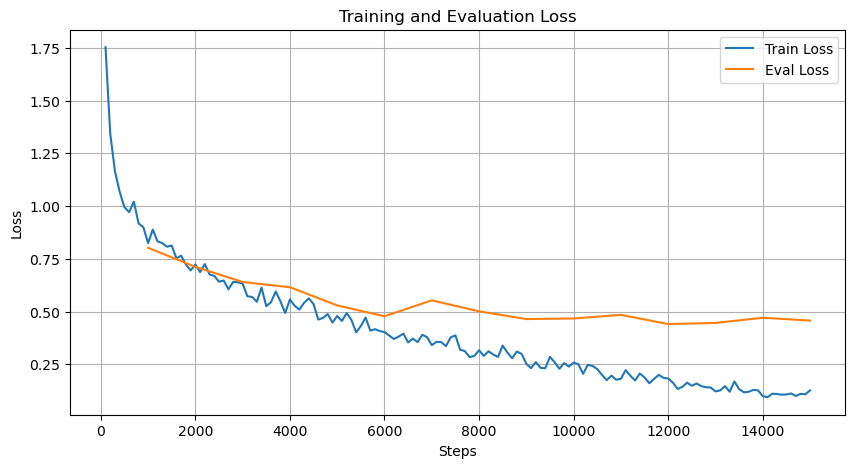

C:\Users\kaiha\AppData\Local\Temp\ipykernel_39780\1363848515.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensor_data = torch.tensor(self.data[idx], dtype=torch.float)
C:\Users\kaiha\AppData\Local\Temp\ipykernel_39780\1363848515.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.labels[idx], dtype=torch.long)


  0%|          | 0/750 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.78      0.93      0.85      1041
           2       0.93      0.91      0.92       719
           3       0.99      0.99      0.99       243
           4       0.97      0.96      0.97       960
           5       0.94      0.91      0.92       774
           6       0.89      0.82      0.86       926
           7       0.85      0.80      0.83       964
           8       0.81      0.75      0.78       373

    accuracy                           0.88      6000
   macro avg       0.89      0.88      0.89      6000
weighted avg       0.89      0.88      0.88      6000



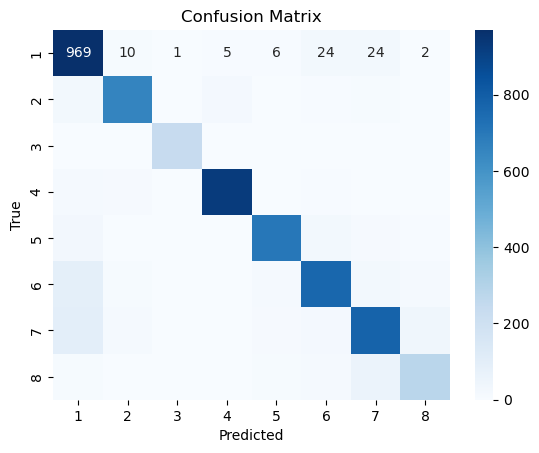

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

#final_evaluation = trainer.evaluate()

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# 最後の評価結果を追加
#eval_loss.append(final_evaluation["eval_loss"])
#eval_steps.append(trainer.state.global_step)

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
#true_labels = eval_dataset["labels"]
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1,9)], yticklabels=[str(i) for i in range(1,9)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [44]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput

class SensorDistilBERT(nn.Module):
    def __init__(self, num_sensor_dims=9, num_labels=8):
        super(SensorDistilBERT, self).__init__()
        self.config = DistilBertModel.from_pretrained("distilbert-base-uncased").config

        self.bert = DistilBertModel(self.config)

        # センサデータ用のエンベディング層
        self.sensor_embedding = nn.Linear(num_sensor_dims, self.config.hidden_size)
        # ポジションエンベディング
        self.position_embeddings = nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size)
        # 出力の分類層
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        
        # Dropout層
        self.dropout = nn.Dropout(self.config.seq_classif_dropout)

    def forward(self, sensor_data, attention_mask=None, labels=None):
        # センサデータをエンベディング層に通す
        batch_size, seq_length, _ = sensor_data.size()
        sensor_embeds = self.sensor_embedding(sensor_data.view(batch_size * seq_length, -1))
        sensor_embeds = sensor_embeds.view(batch_size, seq_length, -1)

        # ポジションエンベディング層
        position_ids = torch.arange(seq_length, dtype=torch.long, device=sensor_embeds.device)
        position_ids = position_ids.unsqueeze(0).expand(sensor_embeds.size(0), seq_length)
        position_embeds = self.position_embeddings(position_ids)

        # エンベディングを加算
        embeddings = sensor_embeds + position_embeds

        # distilBERTのトランスフォーマ層に入力 embeddingsは用意したものを利用する形で
        outputs = self.bert(inputs_embeds=embeddings, attention_mask=attention_mask)

        # [CLS]トークンの出力を取得
        pooled_output = outputs.last_hidden_state[:, 0, :]  # すべてのバッチ、シーケンスの先頭という意味ね
        pooled_output = self.dropout(pooled_output)

        # 分類層に通す
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)  # 形状が一致するように修正

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

# データセットの修正
import torch
from torch.utils.data import Dataset

class SensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sensor_data = torch.tensor(self.data[idx], dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)

        attention_mask = torch.ones(sensor_data.shape[0], dtype=torch.long)  # (500,) の形状になるように

        return {
            "sensor_data": sensor_data,
            "attention_mask": attention_mask,
            "labels": labels
        }

# トレーニングコード
# トレーニング設定
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    logging_dir="./logs",
    logging_steps=100,
)

# サンプルデータの準備
sensor_data = torch.randn(1000, 500, 9)  # 1000サンプル、500シーケンス、9センサ
labels = torch.randint(0, 8, (1000,))

# データセットの準備
train_dataset = SensorDataset(sensor_data, labels)

# トレーナーの定義
model = SensorDistilBERT(num_labels=8)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# トレーニングの実行
trainer.train()


  0%|          | 0/96 [00:00<?, ?it/s]

C:\Users\kaiha\AppData\Local\Temp\ipykernel_25956\946019792.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensor_data = torch.tensor(self.data[idx], dtype=torch.float)
C:\Users\kaiha\AppData\Local\Temp\ipykernel_25956\946019792.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.labels[idx], dtype=torch.long)


OutOfMemoryError: CUDA out of memory. Tried to allocate 368.00 MiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 10.62 GiB is allocated by PyTorch, and 490.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [28]:
print(sensor_data.shape, labels.shape)
print(train_xyz.shape, train_label.shape)

torch.Size([1000, 500, 9]) torch.Size([1000])
torch.Size([24000, 9, 500]) torch.Size([24000])
